In [3]:
import pandas as pd
import numpy as np
import os
import boto3

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import seaborn as sns
from shapely.geometry import Point, Polygon

from requests import get
from bs4 import BeautifulSoup

In [27]:
df = pd.read_json("df_ds_tx_prepared.json")

df.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,tokenized,stemmed,lemmatized
0,2021-02-03,Data Scientist Sr. Associate\nnew,"JPMorgan Chase Bank, N.A.",3.9,https://www.indeed.com/rc/clk?jk=dfd1ed6ece073...,The Data Scientist is an individual contributo...,Lewisville,TX,0,data scientist individual contributor able app...,the data scientist is an individual contributo...,the data scientist is an individu contributor ...,the data scientist is an individual contributo...
1,2021-02-03,Data Scientist\nnew,Booz Allen Hamilton,3.9,https://www.indeed.com/rc/clk?jk=246ba9f708c3e...,The Challenge:\nAre you excited at the prospec...,San Antonio,TX,0,challenge excited prospect unlocking secret he...,the challenge\nare you excited at the prospect...,the challeng are you excit at the prospect of ...,the challenge are you excited at the prospect ...
2,2021-02-03,Human Performance Data Analyst Mid/Sr\nnew,Booz Allen Hamilton,3.9,https://www.indeed.com/rc/clk?jk=2538d333374b7...,Key Role:\nServe as a Human Performance Data A...,San Antonio,TX,0,key role serve human performance data analyst ...,key role\nserve as a human performance data an...,key role serv as a human perform data analyst ...,key role serve a a human performance data anal...
3,2021-02-03,Professional-Data Scientist\nnew,AT&T,3.7,https://www.indeed.com/rc/clk?jk=c4841a42f1129...,Overall Purpose: THIS JOB REQUIRES SPECIAL APP...,Plano,TX,0,overall purpose job requires special approval ...,overall purpose this job requires special appr...,overal purpos thi job requir special approv fr...,overall purpose this job requires special appr...
4,2021-02-03,Sr. Data Scientist (Remote)\nnew,Ayasdi,2.3,https://www.indeed.com/rc/clk?jk=57ec78190a3c2...,Ayasdi is breaking new ground in enterprise AI...,Austin,TX,78708,ayasdi breaking new ground enterprise ai looki...,ayasdi is breaking new ground in enterprise ai...,ayasdi is break new ground in enterpris ai and...,ayasdi is breaking new ground in enterprise ai...


In [7]:
type(df.date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
df.date.min()

Timestamp('2020-12-22 00:00:00')

In [9]:
df.date.max()

Timestamp('2021-02-03 00:00:00')

In [34]:
df = df.set_index('date').sort_index()

<AxesSubplot:xlabel='date'>

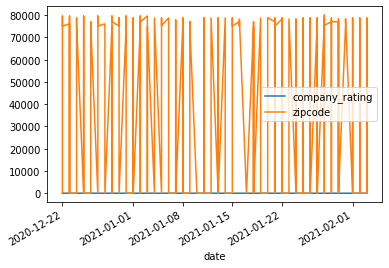

In [35]:
df.plot()

In [31]:
df.date.value_counts()

2020-12-22    248
2020-12-23     73
2021-01-22     72
2021-01-21     62
2021-01-20     55
2021-01-28     51
2021-01-26     49
2021-01-14     32
2021-01-07     32
2021-01-23     31
2021-01-27     31
2020-12-29     31
2020-12-30     30
2021-01-04     29
2021-01-19     28
2021-02-02     27
2021-01-15     26
2021-01-03     24
2020-12-26     23
2020-12-25     23
2020-12-27     22
2021-01-29     21
2021-01-25     20
2021-01-13     20
2021-01-08     19
2020-12-31     19
2021-01-02     18
2021-01-12     18
2021-01-06     16
2021-01-24     16
2021-02-01     15
2021-01-30     14
2021-02-03     12
2021-01-01     11
2021-01-05     10
2021-01-11      9
2021-01-18      9
2021-01-17      5
2021-01-09      5
2021-01-31      4
2021-01-16      3
2020-12-24      3
2020-12-28      3
2021-01-10      1
Name: date, dtype: int64

In [27]:
df.company.value_counts().head(20)

Cognizant Technology Solutions    50
Dell Technologies                 32
Deloitte                          30
USAA                              25
Facebook                          20
StataCorp                         17
Apple                             17
JPMorgan Chase Bank, N.A.         17
KPMG                              16
Indeed                            16
Pearson                           15
Whole Foods Market                14
Wells Fargo                       14
Advanced Micro Devices, Inc.      12
Oportun Inc                       11
Verizon                           11
Herzog Technologies, Inc.         11
O'Neil Digital Solutions          10
Sam's Club                        10
Alcon                             10
Name: company, dtype: int64

In [28]:
df.city.value_counts().head(20)

Austin             369
Dallas             202
Houston            161
San Antonio        102
Plano               96
0                   66
Irving              62
Fort Worth          31
Round Rock          28
Frisco              18
Richardson          17
College Station     17
Addison             12
Abilene              9
Farmers Branch       9
Spring               8
Sugar Land           7
Manor                6
Denton               6
The Woodlands        5
Name: city, dtype: int64

### Creating a geo map for top 3 most prevalent job cities

In [29]:
# filtering df
top3 = df[(df.city == 'Austin') | (df.city == 'Dallas') | (df.city == 'Houston')]

In [30]:
top3['lat'] = np.where((top3['city'] == 'Austin'), 30.267153, None)
top3['lon'] = np.where((top3['city'] == 'Austin'), -97.743057, None)

top3['lat'] = np.where((top3['city'] == 'Dallas'), 32.776665, top3.lat)
top3['lon'] = np.where((top3['city'] == 'Dallas'), -96.796989, top3.lon)

top3['lat'] = np.where((top3['city'] == 'Houston'), 29.760427, top3.lat)
top3['lon'] = np.where((top3['city'] == 'Houston'), -95.369804, top3.lon)

In [31]:
top3.head(2)

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,tokenized,stemmed,lemmatized,lat,lon
4,2021-02-03,Sr. Data Scientist (Remote)\nnew,Ayasdi,2.3,https://www.indeed.com/rc/clk?jk=57ec78190a3c2...,Ayasdi is breaking new ground in enterprise AI...,Austin,TX,78708,ayasdi breaking new ground enterprise ai looki...,ayasdi is breaking new ground in enterprise ai...,ayasdi is break new ground in enterpris ai and...,ayasdi is breaking new ground in enterprise ai...,30.2672,-97.7431
5,2021-02-03,Senior ML Engineer (NLP)\nnew,SIS,3.5,https://www.indeed.com/rc/clk?jk=8e6753c332433...,Type: W2 Inc Description:\nSenior NLP / ML Eng...,Austin,TX,0,type w2 inc description senior nlp ml engineer...,type w2 inc description\nsenior nlp ml enginee...,type w2 inc descript senior nlp ml engin clien...,type w2 inc description senior nlp ml engineer...,30.2672,-97.7431


In [35]:
states = gpd.read_file('cb_2014_us_state_500k.shp')

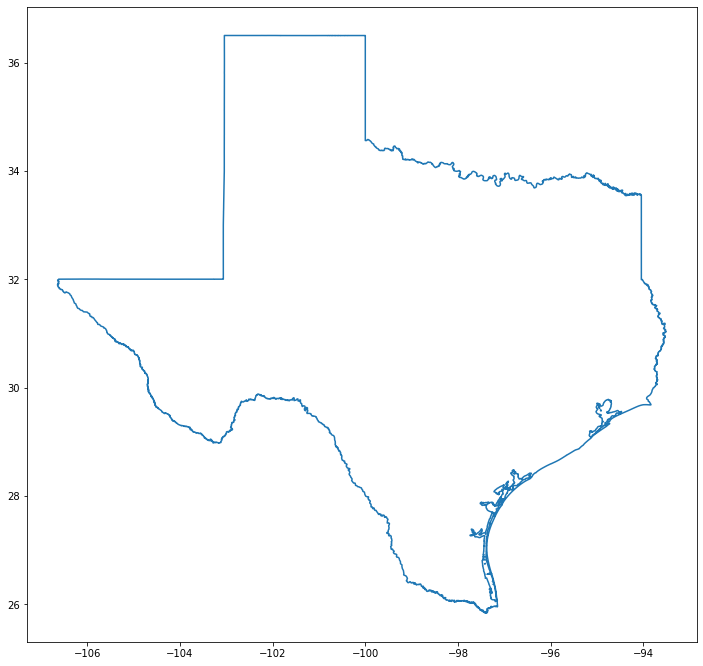

In [49]:
texas = states[states['NAME'] == 'Texas'].boundary.plot(figsize=(12, 12))

In [50]:
texas

In [42]:
def df_to_gdf(df):
    coordinates = df[['lat', 'lon']].astype(float).values
    coordinates = pd.DataFrame(data = coordinates)
    coordinates.columns = ['lat', 'lon']
    coordinates = [Point(xy) for xy in zip(coordinates.lon, coordinates.lat)]
    geo_df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=coordinates)
    return geo_df

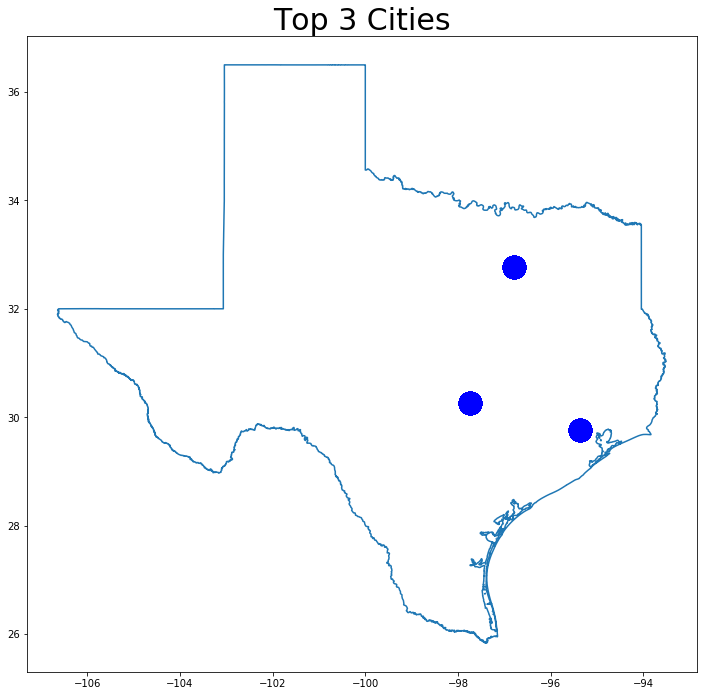

In [57]:
# loading world map
#earth_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#base = earth_map.plot(color='white', edgecolor='black', figsize = (20,25))

texas = states[states['NAME'] == 'Texas'].boundary.plot(figsize=(12, 12))
# creating dataframe for geoplot
texas_data = df_to_gdf(top3)

# plotting map
texas_data.plot(ax = texas, marker = 'o', color = 'blue', markersize=500)

plt.title('Top 3 Cities', fontsize=30)
plt.show()

In [48]:
texas

# Web Scraping for Top Data Science Soft Skills

In [68]:
url = 'https://www.simplilearn.com/soft-skills-for-data-scientist-article'
response = get(url)

In [69]:
response

<Response [200]>

In [70]:
print(response.text[:])

<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" dir="ltr" lang="en-US">
	<head>
	
        <meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
        <meta http-equiv="X-UA-Compatible" content=IE=edge />
        <title>The Soft Skills That Are An Asset to Every Data Scientist</title>
        
        <link rel="dns-prefetch" href="https://ssl.google-analytics.com/">
        <link rel="dns-prefetch" href="https://js-agent.newrelic.com/">
        <link rel="dns-prefetch" href="https://stats.g.doubleclick.net/"/>
        <link rel="dns-prefetch" href="https://www.google.com/"/>

        
        <link rel="shortcut icon" href="https://www.simplilearn.com/static/frontend/images/favicon.png" />
        <link rel="manifest" href="https://www.simplilearn.com/static-frs/manifest.json">
        <link rel="icon" href="https://www.simplilearn.com/static/frontend/images/favicon/favicon.ico" />
        <link rel="apple-touch-icon" sizes="152x152" href="https://www.simpli

In [71]:
soup = BeautifulSoup(response.content)

In [72]:
soup.find_all?

In [73]:
ds_skills = soup.find_all('h3')

ds_skills

[<h3>Data Science vs. Big Data vs. Data Analytics</h3>,
 <h3>Learn Tableau: 10 Tips to Start</h3>,
 <h3>Introduction to Data Science: A Beginner's Guide</h3>,
 <h3>The Intersection of ITSM and Machine Learning</h3>,
 <h3>How Machine Learning is Changing Video Creation</h3>,
 <h3>Everything You Need to Know About Classification in Machine Learning</h3>,
 <h3>Data Science vs. Data Analytics vs. Machine Learning: Expert Talk</h3>,
 <h3>Data Analyst vs. Data Scientist: What's the Difference?</h3>,
 <h3>Data Scientist or Data Engineer? Mapping Educational &amp; Career Opportunities</h3>,
 <h3>How Facebook is Using Big Data - The Good, the Bad, and the Ugly</h3>,
 <h3>Communication</h3>,
 <h3>Curiosity</h3>,
 <h3>Business Acumen</h3>,
 <h3>Storytelling</h3>,
 <h3>Adaptability</h3>,
 <h3>Critical Thinking</h3>,
 <h3>Product Understanding</h3>,
 <h3>Team Player</h3>,
 <h3>Practicing Data Science Skills on a Budget</h3>]

In [75]:
for x in ds_skills:
    if len(x.text.split()) < 3:
        print(x.text)

Communication
Curiosity
Business Acumen
Storytelling
Adaptability
Critical Thinking
Product Understanding
Team Player


# Web Scraping for Top General Soft Skills

In [117]:
url = 'https://www.developgoodhabits.com/soft-skills-list/'
headers = {'User-Agent': 'Data Scientist'}
response = get(url, headers = headers)

response

<Response [200]>

In [118]:
soup = BeautifulSoup(response.content)

In [119]:
softskills = soup.find_all('h3')

In [120]:
skill_list = []

for x in softskills:
    skill_list.append(x.text)

skill_list

['1. Verbal Communication',
 '2. Non-Verbal Communication',
 '3. Visual Communication',
 '4. Written Communication',
 '5. Active Listening',
 '6. Clarity',
 '7. Confidence',
 '8. Interviewing',
 '9. Negotiation',
 '10. Personal Branding',
 '11. Persuasion',
 '12. Presentation Skills',
 '13. Public Speaking',
 '14. Storytelling',
 '15. Diplomacy',
 '16. Empathy',
 '17. Friendliness',
 '18. Humor',
 '19. Networking',
 '20. Patience',
 '21. Positive Reinforcement',
 '22. Sensitivity',
 '23. Tolerance',
 '24. Analysis',
 '25. Artistic Sense',
 '26. Brainstorming',
 '27. Design',
 '28. Design Sense',
 '29. Divergent Thinking',
 '30. Experimenting',
 '31. Imagination',
 '32. Innovation',
 '33. Insight',
 '34. Inspiration',
 '35. Lateral Thinking',
 '36. Logical Reasoning',
 '37. Mind Mapping',
 '38. Observation',
 '39. Persistence',
 '40. Questioning',
 '41. Reframing',
 '42. Troubleshooting',
 '43. People Management',
 '44. Project Management',
 '45. Remote Team Management',
 '46. Talent Ma

In [121]:
len(skill_list)

135

In [122]:
numdot = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '.']
clean_skill_list = []
for x in skill_list:
    clean_skill_list.append(''.join(i for i in x if not i in numdot).strip())
    
clean_skill_list


['Verbal Communication',
 'Non-Verbal Communication',
 'Visual Communication',
 'Written Communication',
 'Active Listening',
 'Clarity',
 'Confidence',
 'Interviewing',
 'Negotiation',
 'Personal Branding',
 'Persuasion',
 'Presentation Skills',
 'Public Speaking',
 'Storytelling',
 'Diplomacy',
 'Empathy',
 'Friendliness',
 'Humor',
 'Networking',
 'Patience',
 'Positive Reinforcement',
 'Sensitivity',
 'Tolerance',
 'Analysis',
 'Artistic Sense',
 'Brainstorming',
 'Design',
 'Design Sense',
 'Divergent Thinking',
 'Experimenting',
 'Imagination',
 'Innovation',
 'Insight',
 'Inspiration',
 'Lateral Thinking',
 'Logical Reasoning',
 'Mind Mapping',
 'Observation',
 'Persistence',
 'Questioning',
 'Reframing',
 'Troubleshooting',
 'People Management',
 'Project Management',
 'Remote Team Management',
 'Talent Management',
 'Virtual Team Management',
 'Meeting Management',
 'Agility',
 'Coaching',
 'Conflict or Dispute Resolution',
 'Cultural Intelligence',
 'Deal-Making',
 'Decision-

In [125]:
clean_skill_list_series = pd.Series(clean_skill_list)

In [137]:
cwd = os.getcwd()
path = cwd + "/soft_skills_cleaned"
clean_skill_list_series.to_csv(path, index=False)

In [145]:
s3 = boto3.resource('s3')

# Locate the S3 bucket named 'additionaljobinfo'
additional_info = s3.Bucket('additionaljobinfo')

# Upload the geospatial file to the additionaljobinfo bucket.
additional_info.upload_file('soft_skills_cleaned', 'soft_skills_cleaned')